In [1]:
import torch
from torch import nn,optim
from torchvision import datasets,transforms
from torch.autograd.variable import Variable
import numpy as np
import matplotlib.pyplot as plt
import tensorboard
from utils import Logger

In [2]:
def mnist_data():
    compose=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5) # (-1,1)
        # mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, 
        # this transform will normalize each channel of the input
    ])
    path='./dataset'
    return datasets.MNIST(path,train=True,download=True,transform=compose)

batch_size=100
data=mnist_data()
data_loader=torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=True)
num_batches=len(data_loader)
print(f'num_batchses = {num_batches}')

num_batchses = 600


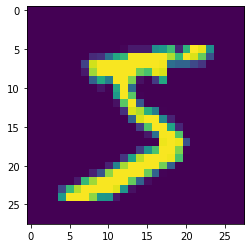

torch.Size([1, 28, 28])
5


In [3]:
img,label=data[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(img.size())
print(label)

In [4]:
device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(device)

cuda


In [5]:
class DiscriminatorNet(nn.Module):
    def __init__(self,in_featrue,out_features=1):
        super().__init__()
        self.block0=nn.Sequential(
            nn.Linear(in_featrue,1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=0.3)
        )
        self.block1=nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=0.3)
        )
        self.block2=nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=0.3)
        )
        self.block3=nn.Sequential(
            nn.Linear(256,out_features),
            nn.Sigmoid() # (0,1)
        )
    def forward(self,x):
        x=self.block0(x)
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        return x

discriminator=DiscriminatorNet(28*28,1).to(device)
print(f'discriminator device : {next(discriminator.parameters()).device}')

discriminator device : cuda:0


In [6]:
def images_to_vectors(images):
    return images.view(images.size(0),28*28)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0),1,28,28)

In [7]:
class GeneratorNet(nn.Module):
    """
   The Generative Network takes a latent variable vector as input, 
    and returns a 784 valued vector, which corresponds to a flattened 28x28 image.
    """
    def __init__(self,in_feature,out_featrure):
        super().__init__()
        self.block0=nn.Sequential(
            nn.Linear(in_feature,256),
            nn.LeakyReLU(0.2)
        )
        self.block1=nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU(0.2)
        )
        self.block2=nn.Sequential(
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2)
        )
        self.block3=nn.Sequential(
            nn.Linear(1024,out_featrure),
            nn.Tanh() # map the resulting values into the (-1, 1) range
        )
    def forward(self,x):
        x=self.block0(x)
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        return x
    
generator=GeneratorNet(100,28*28).to(device)
print(f'generator device : {next(generator.parameters()).device}')

generator device : cuda:0


In [8]:
def noise(size):
    """
    Generates a 1-d vector of gaussian sampled random values.
    """
    # n=Variable(torch.randn(size,100)) 
    # The Variable API has been deprecated
    # It still work as expected, but they return Tensors instead of Variables
    n=torch.randn(size,100,requires_grad=True)
    # Returns a tensor filled with random numbers from a standard normal distribution
    return n

In [9]:
learning_rate=0.0002
d_optimizer=optim.Adam(discriminator.parameters(),lr=learning_rate)
g_optimizer=optim.Adam(generator.parameters(),lr=learning_rate)

In [10]:
"""
The loss function we’ll be using for this task is named Binary Cross Entopy Loss (BCE Loss), 
and it will be used for this scenario as it resembles the log-loss for both the Generator and Discriminator defined earlier
"""
loss_fn=nn.BCELoss()

In [11]:
def ones_target(size):
    return torch.ones((size,1),requires_grad=True)

def zeros_target(size):
    return torch.zeros((size,1),requires_grad=True)

In [12]:
def train_discriminator(optimizer,real_data,fake_data):
    real_data=real_data.to(device)
    fake_data=fake_data.to(device)
    N=real_data.size(0)
    optimizer.zero_grad()
    # 1.Train on Real Data
    pred_real=discriminator(real_data) 
    error_real=loss_fn(pred_real,ones_target(N).to(device)) # input,target
    error_real.backward()
    # 2.Train on Fake Data
    pred_fake=discriminator(fake_data) 
    error_fake=loss_fn(pred_fake,zeros_target(N).to(device)) # input,target
    error_fake.backward()
    # 3.Update weights with gradients
    optimizer.step()

    return error_real+error_fake,pred_real,pred_fake

In [13]:
def train_generator(optimizer,fake_data):
    fake_data=fake_data.to(device)
    N=fake_data.size(0)
    optimizer.zero_grad()
    # Sample noise and generate fake data
    pred=discriminator(fake_data)
    # Calculate error and backpropagate
    error=loss_fn(pred,ones_target(N).to(device))
    error.backward()
    # Update weights with gradients
    optimizer.step()

    return error

In [14]:
num_test_samples = 16
test_noise = noise(num_test_samples).to(device)

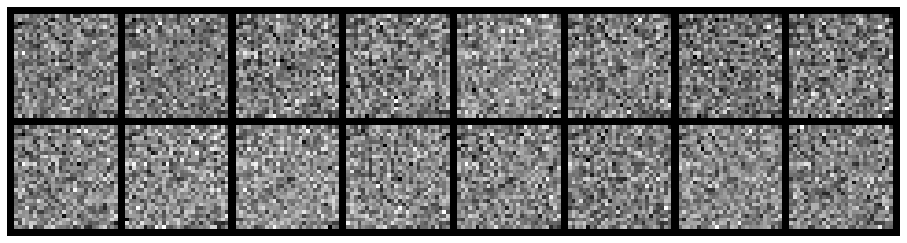

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3671, Generator Loss: 0.6876
D(x): 0.5123, D(G(z)): 0.5024


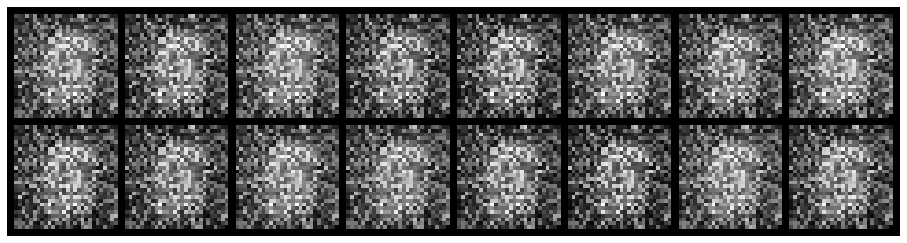

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 2.1212, Generator Loss: 0.3899
D(x): 0.8704, D(G(z)): 0.8446


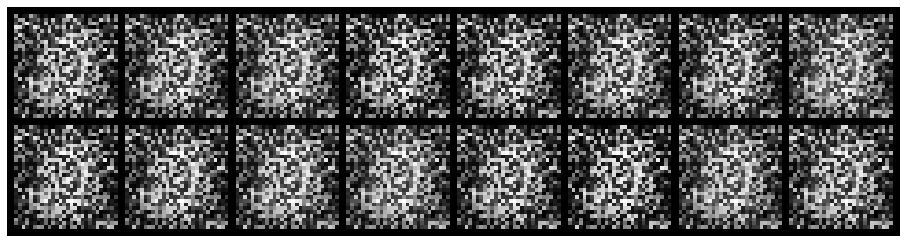

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 1.1887, Generator Loss: 2.0946
D(x): 0.7084, D(G(z)): 0.5024


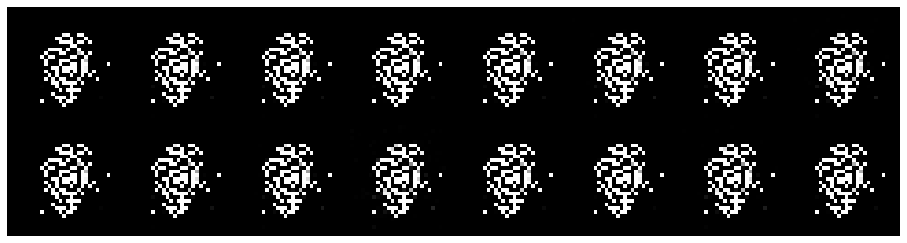

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.0142, Generator Loss: 6.2800
D(x): 0.9925, D(G(z)): 0.0064


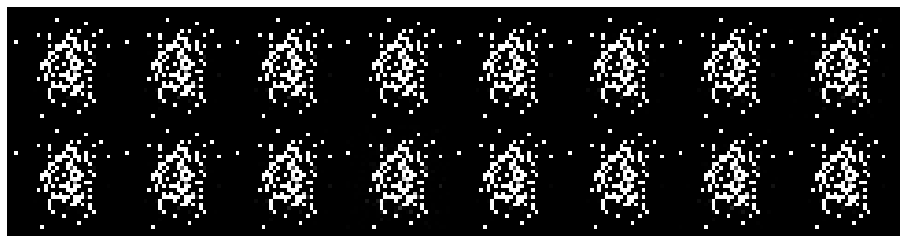

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.0016, Generator Loss: 9.9175
D(x): 0.9987, D(G(z)): 0.0004


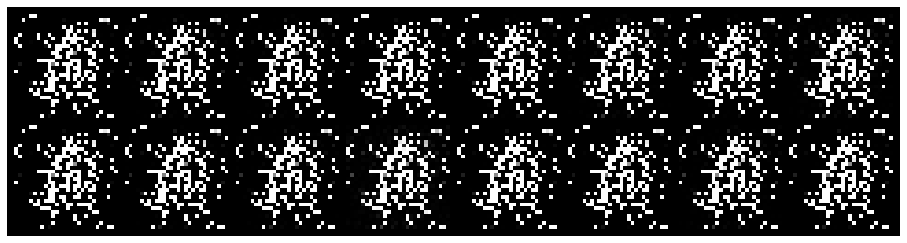

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.0075, Generator Loss: 7.7513
D(x): 0.9952, D(G(z)): 0.0027


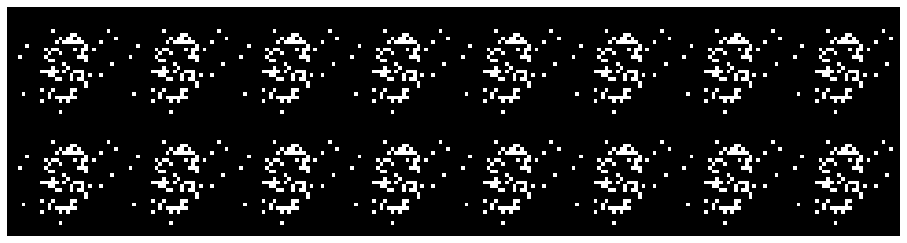

Epoch: [100/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 44.6765
D(x): 1.0000, D(G(z)): 0.0000


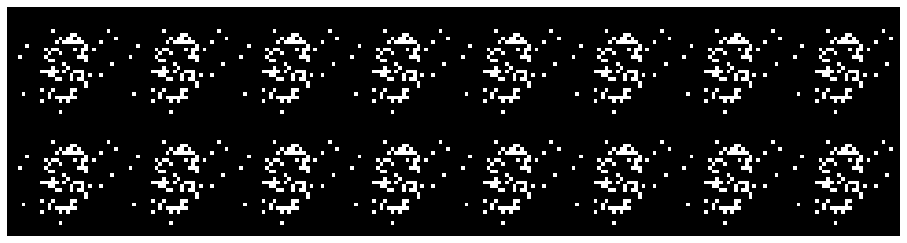

Epoch: [100/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 44.4395
D(x): 1.0000, D(G(z)): 0.0000


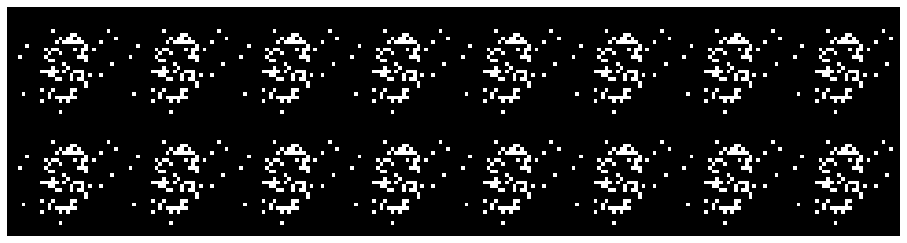

Epoch: [100/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 44.9517
D(x): 1.0000, D(G(z)): 0.0000


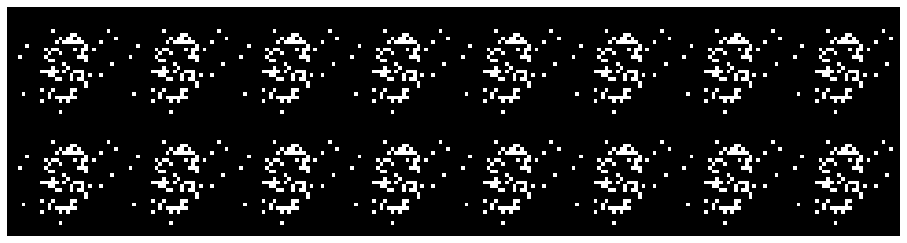

Epoch: [100/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 44.6289
D(x): 1.0000, D(G(z)): 0.0000


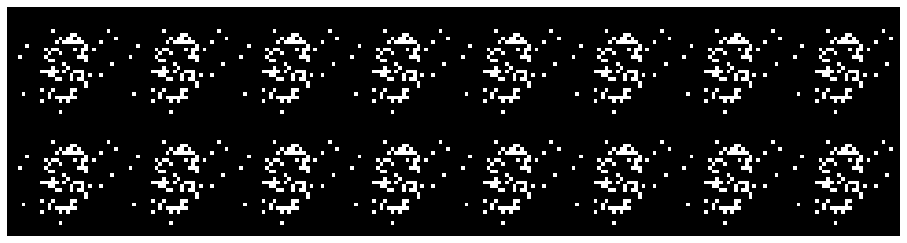

Epoch: [100/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 44.4430
D(x): 1.0000, D(G(z)): 0.0000


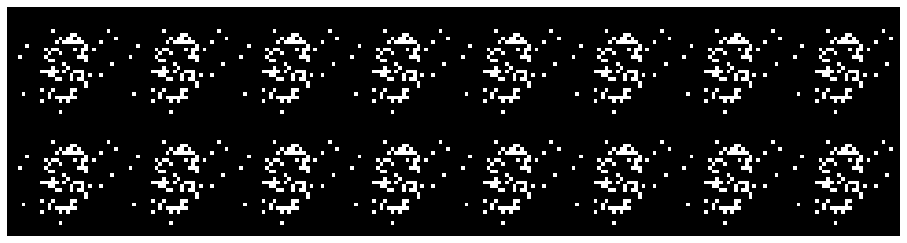

Epoch: [100/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 44.4152
D(x): 1.0000, D(G(z)): 0.0000


In [15]:
logger=Logger(model_name='VGAN',data_name='MNIST')
num_epochs=200
for epoch in range(num_epochs):
    for n_batch,(real_batch,_) in enumerate(data_loader):
        real_batch=real_batch.to(device)
        N=real_batch.size(0)
        # 1.Train Discriminator
        real_data=images_to_vectors(real_batch).to(device)
        # Generate fake data and detach
        # (so gradients are not calculated for generator)
        fake_data=generator(noise(N).to(device)).detach()
        # Train D
        d_error,d_pred_real,d_pred_fake=train_discriminator(d_optimizer,real_data,fake_data)

        # 2.Train Generator
        # Generate fake data
        fake_data = generator(noise(N).to(device))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images.cpu(), num_test_samples, 
                epoch, n_batch, num_batches)
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error.cpu(), g_error.cpu(), d_pred_real.cpu(), d_pred_fake.cpu()
            )
            